created by Ignacio Oguiza - email: oguiza@gmail.com

## How to work with numpy arrays in fastai2: a time series classification example ⏳ 

I'd like to share with you how you can work with (very large) numpy arrays in **fastai2** through a time series classification example. To be able to use fastai v2 I have a few requirements: 


* Use univariate and multivariate time series
* Use labeled (X,y) and unlabeled (X,) datasets
* Data may be already split in train/ valid
* In-memory and on-disk np.arrays (np.memmap in case of larger than RAM data)
* Slice the dataset (based on selected variables and/ or sequence steps)
* Use item and batch tfms
* Create batch with specified output types (TSTensor, TensorCategory, etc)
* Show batch (with tfms)
* Show results
* Add test data and unlabeled datasets
* Export and predict on new data
* Equal or better performance than native Pytorch, fastai v1 & vanilla fastai v2

These are pretty challanging. Let's see if fastai2 can meet them (with limited customization).

## Import libraries 📚

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import sys
import os
ISCOLAB = 'google.colab' in sys.modules
if ISCOLAB:
    if not os.path.isdir('/content/timeseriesAI2'):
        !pip install git+https://github.com/fastai/fastai2 
        !pip install git+https://github.com/fastai/fastcore 
        !pip install pyunpack
        !pip install sktime
        !git clone https://github.com/timeseriesAI/timeseriesAI2.git
        %cd timeseriesAI2
    else: 
        path = !pwd
        if path != ['/content/timeseriesAI2']: 
            %cd timeseriesAI2
        !pwd

In [4]:
# # Uncomment if need to reload repo
# %cd ..
# !rm -rf timeseriesAI2

# !git clone https://github.com/timeseriesAI/timeseriesAI2.git
# %cd timeseriesAI2

In [5]:
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

In [6]:
from timeseries.imports import *
from timeseries.utils import *
from timeseries.data import *
from timeseries.core import *
from timeseries.models import *

In [7]:
print('fastai2    :', fastai2.__version__)
print('fastcore   :', fastcore.__version__)
print('torch      :', torch.__version__)
print('scipy      :', sp.__version__)
print('numpy      :', np.__version__)
print('pandas     :', pd.__version__)
PATH = Path("/content/drive/My Drive/BB") if ISCOLAB else Path('data/trading/BB')
print('path       :', PATH)
print(f'Total RAM  : {bytes2GB(psutil.virtual_memory().total):5.2f} GB')
print(f'Used RAM   : {bytes2GB(psutil.virtual_memory().used):5.2f} GB')
print('n_cpus     :', cpus)
iscuda = torch.cuda.is_available()
if iscuda: print('device     : {} ({})'.format(device, torch.cuda.get_device_name(0)))
else: print('device     :', device)

fastai2    : 0.0.16
fastcore   : 0.1.17
torch      : 1.4.0
scipy      : 1.3.1
numpy      : 1.18.1
pandas     : 0.25.1
path       : data/trading/BB
Total RAM  :  8.00 GB
Used RAM   :  3.87 GB
n_cpus     : 8
device     : cpu


## Load data 🔢

In [30]:
# dataset id
dsid = 'StarLightCurves'
X_train, y_train, X_valid, y_valid = get_UCR_data(dsid, parent_dir='./data/UCR/', verbose=True, on_disk=True)
X_in_memory = np.concatenate((X_train, X_valid))
y_in_memory = np.concatenate((y_train, y_valid))
folder = './data/UCR'
np.save(f'{folder}/{dsid}/X.npy', X_in_memory)
np.save(f'{folder}/{dsid}/y.npy', y_in_memory)
X_on_disk = np.load(f'{folder}/{dsid}/X.npy', mmap_mode='r')
y_on_disk = np.load(f'{folder}/{dsid}/y.npy', mmap_mode='r')
splits = (L(list(np.arange(len(X_train)))), L(list(np.arange(len(X_train), len(X_on_disk)))))

Dataset: StarLightCurves
X_train: (1000, 1, 1024)
y_train: (1000,)
X_valid: (8236, 1, 1024)
y_valid: (8236,) 



## Building block: TSTensor 🧱

Since fastai is based on Pytorch, you'll need to somehow transform the numpy arrays to tensors at some point (Tensor or TSTensor in our case). There's a transform function called ToTensor/ ToTSTensor that transforms an array into a tensor of type Tensor/ TSTensor (which has a show method).

In [17]:
class NumpyTensor(TensorBase):

    def __new__(cls, o, **kwargs): 
        res = ToTensor(o)
        res.__class__ = cls
        res._meta = kwargs
        return res
    
    def __getitem__(self, idx):
        res = super().__getitem__(idx)
        return retain_type(res, self)

    def show(self, ax=None, ctx=None, title=None, **kwargs):
        ax = ifnone(ax,ctx)
        if ax is None: fig, ax = plt.subplots(**kwargs)
        ax.plot(self.T)
        ax.axis(xmin=0, xmax=self.shape[-1] - 1)
        ax.set_title(title, weight='bold')
        plt.tight_layout()
        return ax

@Transform
def ToNumpyTensor(o:np.ndarray): 
    return NumpyTensor(o)


class TSTensor(TensorBase):
    '''Returns a tensor of at least 2 dims of type torch.float32 and class TSTensor'''
    def __new__(cls, o, dtype=torch.float32, **kwargs): 
        res = ToType(dtype)(To2DPlusTensor(o))
        res.__class__ = cls
        res._meta = kwargs
        return res

    @property
    def vars(self): return self.shape[-2]

    @property
    def length(self): return self.shape[-1]
    
    def __getitem__(self, idx):
        res = super().__getitem__(idx)
        return retain_type(res, self)

    def __repr__(self):
        if self.ndim >= 3:   return f'TSTensor(samples:{self.shape[-3]}, vars:{self.shape[-2]}, len:{self.shape[-1]})'
        elif self.ndim == 2: return f'TSTensor(vars:{self.shape[-2]}, len:{self.shape[-1]})'
        elif self.ndim == 1: return f'TSTensor(len:{self.shape[-1]})'
        else: return f'TSTensor(float)'

    def show(self, ax=None, ctx=None, title=None, title_color='black', **kwargs):
        ax = ifnone(ax,ctx)
        if ax is None: fig, ax = plt.subplots(**kwargs)
        ax.plot(self.T)
        ax.axis(xmin=0, xmax=self.shape[-1] - 1)
        ax.set_title(title, weight='bold', color=title_color)
        plt.tight_layout()
        return ax

@Transform
def ToTSTensor(o:np.ndarray, dtype=torch.float32, **kwargs): 
    """ Transforms input to tensor of dtype torch.float32"""
    return TSTensor(o, dtype=dtype, **kwargs)

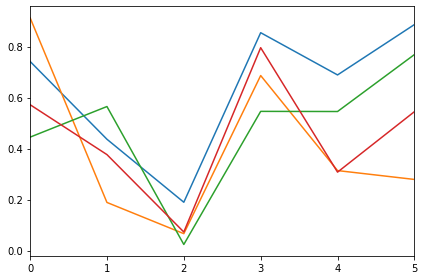

In [14]:
nt = NumpyTensor(np.random.rand(4, 6))
nt.show();

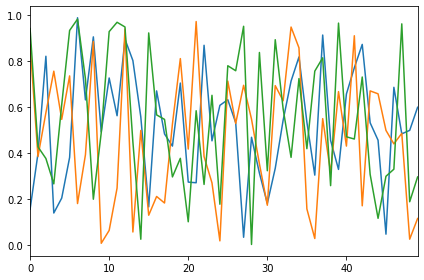

In [16]:
tstensor = TSTensor(np.random.rand(10, 3, 50))
tstensor[0].show();

## Performance benchmarks ⏱

In fastai v2 there are multiple options to creaet a dataloaders. Let's see some of them and most importantly wheteher they meet our requirements.

I will compare 2 processes: 

- cycle_dl: process to load the entire valid dataset (adapted from a function developed by Thomas Capelle (fastai's @tcapelle))
- train model for 25 epochs

### Native Pytorch dataloader

In [10]:
# # Native Pytorch
# class PytorchDataset():
#     def __init__(self, X, y=None): self.X, self.y = torch.as_tensor(X), torch.as_tensor(y)
#     def __getitem__(self, idx): return (self.X[idx], self.y[idx])
#     def __len__(self): return len(self.X)

In [284]:
ds    = PytorchDataset(np.array(X_valid), np.array(y_valid).astype(int))
dl    = torch.utils.data.DataLoader(ds, batch_size=128)
xb,yb = next(iter(dl))
print(f'shape: {str(len(ds)):10}   bs: {xb.shape}')
%timeit cycle_dl(dl)

shape: 8236         bs: torch.Size([128, 1, 1024])
10 loops, best of 3: 49.6 ms per loop


This is the most simple dataset we can have. This doesn't allow us to perform any transforms, show_batch, etc. It cannot be used inside fastai.

I've included it for reference, as this dataloader is pretty fast (around 50 ms to cycle the entire dataset). This will be difficult to beat 😅!

### Fastai v1

For comparison, I've run the same exact test in the same machine with fastai v1 timeseries code and these are the timings: : 

- cycle_dl:  1.01s
- training time: 102 s

This 102 seconds is what we'll try to beat.

### Fastai v2:  Factory method

In [18]:
class TSDataLoaders(DataLoaders):
    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_numpy(cls, X, y=None, splitter=None, valid_pct=0.2, seed=0, item_tfms=None, batch_tfms=None, **kwargs):
        "Create timeseries dataloaders from arrays (X and y, unless unlabeled)"
        if splitter is None: splitter = RandomSplitter(valid_pct=valid_pct, seed=seed)
        getters = [ItemGetter(0), ItemGetter(1)] if y is not None else [ItemGetter(0)]
        dblock = DataBlock(blocks=(TSTensorBlock, CategoryBlock),
                           getters=getters,
                           splitter=splitter,
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms)

        source = itemify(X) if y is None else itemify(X,y)
        return cls.from_dblock(dblock, source, **kwargs)

In [20]:
dls = TSDataLoaders.from_numpy(X_in_memory, y_in_memory, splitter=IndexSplitter(splits[1]), bs=64, val_bs=128)
t = next(iter(dls.valid))
t

(TSTensor(samples:128, vars:1, len:1024),
 TensorCategory([1, 2, 2, 0, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 0, 2, 2, 2,
         1, 0, 2, 0, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 0, 2, 2, 1, 0, 0, 2,
         2, 2, 2, 1, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 1, 2, 2, 1, 2, 2, 2, 0, 0, 2,
         1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 0, 2, 0, 2,
         2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 0, 2, 2, 0, 2, 2, 1, 2, 1, 2, 2,
         2, 2, 2, 2, 1, 2, 2, 0]))

In [ ]:
%time cycle_dl(dls.valid)

In [ ]:
model = InceptionTime(X_in_memory.shape[-2], dls.c)
learn = Learner(dls, model, metrics=accuracy)
start = time.time()
learn.fit_one_cycle(25, lr_max=1e-3)
print(time.time() - start)

This method is very easy to use, but it's pretty slow.

### Fastai v2:  Datablock API

In [31]:
class TSTensorBlock():
    "A basic wrapper that links defaults transforms for the data block API"
    def __init__(self, type_tfms=None, item_tfms=None, batch_tfms=None, dl_type=None, dls_kwargs=None):
        self.type_tfms  =              L(type_tfms)
        self.item_tfms  = ToTSTensor + L(item_tfms)
        self.batch_tfms =              L(batch_tfms)
        self.dl_type,self.dls_kwargs = dl_type,({} if dls_kwargs is None else dls_kwargs)

In [33]:
getters = [ItemGetter(0), ItemGetter(1)]
# dblock = DataBlock(blocks=(TSTensorBlock, CategoryBlock()),
dblock = DataBlock(blocks=(TSTensorBlock, TransformBlock()),
                   getters=getters,
                   splitter=IndexSplitter(splits[1]),
                   item_tfms=None,
                   batch_tfms=None)
source = itemify(X_in_memory, y_in_memory)
dls = dblock.dataloaders(source, bs=64, val_bs=128, num_workers=0)
xb,yb = next(iter(dls.valid))
print(f'shape: {str(len(dls.valid.dataset)):10}   bs: {xb.shape}')
%timeit cycle_dl(dls.valid)

shape: 8236         bs: torch.Size([128, 1, 1024])


KeyboardInterrupt: 

So it takes > 3 s to cycle the entire dataloader. This is much slower than Pytorch simple model (although fastai v2 provides a lot more functionality!).

In [17]:
model = InceptionTime(X_in_memory.shape[-2], dls.c)
learn = Learner(dls, model, metrics=accuracy)
start = time.time()
learn.fit_one_cycle(25, lr_max=1e-3)
print(time.time() - start)

epoch,train_loss,valid_loss,accuracy,time
0,0.667969,0.938211,0.577222,00:06
1,0.547302,0.660070,0.782904,00:06
2,0.468812,0.405052,0.839000,00:06
3,0.398324,0.374961,0.855148,00:06
4,0.346426,0.451791,0.856605,00:06
5,0.290318,0.191121,0.912215,00:06
6,0.243504,0.280189,0.862555,00:06
7,0.205608,0.177530,0.946576,00:06
8,0.176870,0.370253,0.861098,00:06
9,0.151356,0.106336,0.975838,00:06


161.63079595565796


This is very slow compared to the native Pytorch, and even to fastai v1.

Sylvain Gugger provided an alternative recommendation to use numpy arrays in this [post](https://forums.fast.ai/t/datablock-with-numpy-input/64848/2):

"You can create a DataLoaders object from regular PyTorch datasets (though all the visualization methods like show_batch and show_results will fail)."

In [18]:
train_ds = PytorchDataset(np.array(X_train), np.array(y_train).astype(int) - 1)
valid_ds = PytorchDataset(np.array(X_valid), np.array(y_valid).astype(int) - 1)
dls = DataLoaders.from_dsets(train_ds, valid_ds, batch_size=128, num_workers=0, device=default_device())
xb,yb = next(iter(dls.valid))
print(f'shape: {str(len(dls.valid.dataset)):10}   bs: {xb.shape}')
%timeit cycle_dl(dls.valid)

shape: 8236         bs: torch.Size([128, 1, 1024])
1 loop, best of 3: 751 ms per loop


In [11]:
model = InceptionTime(X_in_memory.shape[-2], len(np.unique(y_in_memory)))
learn = Learner(dls, model, loss_func=nn.CrossEntropyLoss(), metrics=accuracy)
start = time.time()
learn.fit_one_cycle(25, lr_max=1e-3)
print(time.time() - start)

epoch,train_loss,valid_loss,accuracy,time
0,0.915071,1.125882,0.142909,00:03
1,0.752208,1.067526,0.152380,00:03
2,0.641190,0.872242,0.787640,00:03
3,0.562946,0.650465,0.840214,00:03
4,0.497515,0.469241,0.848349,00:03
5,0.440871,0.658852,0.847135,00:03
6,0.395578,0.466469,0.856119,00:03
7,0.349685,0.240354,0.864133,00:03
8,0.314984,0.181429,0.950340,00:03
9,0.284552,0.762271,0.855877,00:03


92.82549476623535


This is definitely an improvement in terms of speed.

It is now better than fastai v1, but still worse than Pytorch. 

## NumpyDatasets & NumpyDataLoader 🤩

So far we we've seen fastai v2 is easy to use, but it's slow compared to v1 (in this example the Datablock API was 60% slower). 

There are at least 3 major differences between vision and time series - TS- (and numpy based data in general) that we can leverage to improve performance: 

1. Vision tipically requires some item preprocessing that is sometimes random. For example, when you randomly crop an image. Each time it'll return a different value. In my experience, most item transforms are **deterministic** (actually most impact the label only).

2. In vision problems, you usually derive the image and label from a single item (path). In TS problems, it's common to have data already **split between X and y**.

3. You can only create an image loading and processing them 1 at a time. However with numpy datasets, you can create a batch **processing all batch items** at the same time, just by slicing an array/ tensor. This is much faster.

The first difference allows us to approach the datasets creation is a different way. Since the tfms will almost always deliver the same output, we can **preprocess** the item tfms at datasets initialization, and thus save this time in every epoch. As you'll see, this results in a much faster dataloder.

It doesn't make much sense to have data already split (into X and y) to merge them in a single item, process them together, and separate again. It'd be easier to just apply the tfms independently to the inputs (X) and labels (y), and then simply slice them. Slicing is a much faster operation than applying a transform, and also allows a significant improvement in terms of speed.

There's **no need to have a collate_fn to create a batch**. The fastest way to do it would be to simply use the batch indices to slice the preprocessed arrays/ tensors all at the same time. 

Based on this, I've created a NumpyDatasets and NumpyDataLoader that leverage the characteristics of numpy-based datasets.

BTW, something important as well, is that NumpyDatasets allows the use of larger than RAM datasets, as data can be sliced directly from disk before loading in memory. 

In [21]:
class NumpyDatasets(Datasets):
    "A dataset that creates tuples from X (and y) and applies `item_tfms`"
    _xtype, _ytype = None, None # Expected X and y output types (torch.Tensor - default - or subclass)
    def __init__(self, X=None, y=None, items=None, sel_vars=None, sel_steps=None, tfms=None, tls=None, n_inp=None, dl_type=None, 
                 preprocess=False, **kwargs):

        if tls is None: items = ifnoneelse(y,tuple((X,)),tuple((X, y)))
        self.tfms = L(ifnone(tfms,[None]*len(ifnone(tls,items))))
        self.sel_vars = slice(None) if sel_vars is None else sel_vars
        self.sel_steps = slice(None) if sel_steps is None else sel_steps
        self.tls = L(tls if tls else [TfmdLists(item, t, **kwargs) for item,t in zip(items,self.tfms)])
        self.n_inp = (1 if len(self.tls)==1 else len(self.tls)-1) if n_inp is None else n_inp
        self.ptls = L([tl.items if is_none(tfm) else np.stack(tl[:]) if preprocess else tl for tl,tfm in zip(self.tls, self.tfms)])
        self.preprocess = preprocess
    
    def __getitem__(self, it):
        return tuple([typ(ptl[it][...,self.sel_vars, self.sel_steps] if i==0 else ptl[it]) for i,(ptl,typ) in enumerate(zip(self.ptls,self.types))])
    
    def subset(self, i): return type(self)(tls=L(tl.subset(i) for tl in self.tls), n_inp=self.n_inp, 
                                           preprocess=self.preprocess, tfms=self.tfms, sel_vars=self.sel_vars, sel_steps=self.sel_steps)
    
    def _new(self, X, *args, y=None, **kwargs): 
        items = ifnone(items,ifnoneelse(y,tuple((X,)),tuple((X, y))))
        return super()._new(items, tfms=self.tfms, do_setup=False, **kwargs)
    
    @property
    def vars(self): return self[0][0].shape[-2]

    @property
    def length(self): return self[0][0].shape[-1]

    @property
    def types(self):
        if self.tls: 
            types = [type(tl[0]) if isinstance(tl[0], torch.Tensor) else torch.as_tensor for tl in self.tls]
            if self._xtype is not None: types[0] = self._xtype
            if len(types) == 2 and self._ytype is not None: types[1] = self._ytype
            return types 


class TSDatasets(NumpyDatasets):
    "A dataset that creates tuples from X (and y) and applies `item_tfms`"
    _xtype, _ytype = TSTensor, None # Expected X and y output types (torch.Tensor - default - or subclass)

def add_ds(dsets, X, y=None, test_items=None, rm_tfms=None, with_labels=False):
    "Create test datasets from X (and y) using validation transforms of `dsets`"
    items = tuple((X,)) if y is None else tuple((X, y))
    with_labels = False if y is None else True
    if isinstance(dsets, (Datasets, NumpyDatasets, TSDatasets)):
        tls = dsets.tls if with_labels else dsets.tls[:dsets.n_inp]
        new_tls = L([tl._new(item, split_idx=1) for tl,item in zip(tls, items)])
        if rm_tfms is None: rm_tfms = [tl.infer_idx(get_first(item)) for tl,item in zip(new_tls, items)]
        else:               rm_tfms = tuplify(rm_tfms, match=new_tls)
        for i,j in enumerate(rm_tfms): new_tls[i].tfms.fs = new_tls[i].tfms.fs[j:]
        if isinstance(dsets, (NumpyDatasets, TSDatasets)):
            cls = dsets.__class__
            return cls(tls=new_tls, n_inp=dsets.n_inp, preprocess=dsets.preprocess, tfms=dsets.tfms, sel_vars=dsets.sel_vars, sel_steps=dsets.sel_steps)
        elif isinstance(dsets, Datasets): return Datasets(tls=new_tls)
    elif isinstance(dsets, TfmdLists):
        new_tl = dsets._new(items, split_idx=1)
        if rm_tfms is None: rm_tfms = dsets.infer_idx(get_first(items))
        new_tl.tfms.fs = new_tl.tfms.fs[rm_tfms:]
        return new_tl
    else: raise Exception(f"This method requires using the fastai library to assemble your data.Expected a `Datasets` or a `TfmdLists` but got {dsets.__class__.__name__}")

def add_test(dsets, X, y=None, test_items=None, rm_tfms=None, with_labels=False):
    return add_ds(dsets, X, y=y, test_items=test_items, rm_tfms=rm_tfms, with_labels=with_labels)

NumpyDatasets.add_test = add_test

def add_unlabeled(dsets, X, test_items=None, rm_tfms=None, with_labels=False):
    return add_ds(dsets, X, y=None, test_items=test_items, rm_tfms=rm_tfms, with_labels=with_labels)

NumpyDatasets.add_unlabeled = add_unlabeled

In [22]:
class NumpyDataLoader(TfmdDL):
    do_item = noops
    
    def create_batch(self, b): return self.dataset[b]
    
    @property
    def vars(self): return self.dataset[0][0].shape[-2]
    
    @property
    def length(self): return self.dataset[0][0].shape[-1]

    @delegates(plt.subplots)
    def show_batch(self, b=None, ctxs=None, max_n=9, nrows=3, ncols=3, figsize=(16, 10), **kwargs):
        b = self.one_batch()
        db = self.decode_batch(b, max_n=max_n)
        if figsize is None: figsize = (ncols*6, max_n//ncols*4)
        if ctxs is None: ctxs = get_grid(min(len(db), nrows*ncols), nrows=None, ncols=ncols, figsize=figsize, **kwargs)
        for i,ctx in enumerate(ctxs):
            show_tuple(db[i], ctx=ctx)

    @delegates(plt.subplots)
    def show_results(self, b, preds, ctxs=None, max_n=9, nrows=3, ncols=3, figsize=(16, 10), **kwargs):
        t = self.decode_batch(b, max_n=max_n)
        p = self.decode_batch((b[0],preds), max_n=max_n)
        if figsize is None: figsize = (ncols*6, max_n//ncols*4)
        if ctxs is None: ctxs = get_grid(min(len(t), nrows*ncols), nrows=None, ncols=ncols, figsize=figsize, **kwargs)
        for i,ctx in enumerate(ctxs): 
            title = f'True: {t[i][1]}\nPred: {p[i][1]}'
            color = 'green' if t[i][1] == p[i][1] else 'red'
            t[i][0].show(ctx=ctx, title=title, title_color=color)


@delegates(plt.subplots)
def show_tuple(tup, **kwargs):
    "Display a timeseries plot from a decoded tuple"
    tup[0].show(title='unlabeled' if len(tup) == 1 else tup[1], **kwargs)
    
class TSDataLoader(NumpyDataLoader): pass

In [23]:
bs = 128
idx = np.random.randint(len(X_in_memory), size=bs)
train_idx = np.random.randint(len(splits[0]), size=bs)
valid_idx = np.random.randint(len(splits[1]), size=bs)

(TSTensor(vars:1, len:1024), TensorCategory(1))


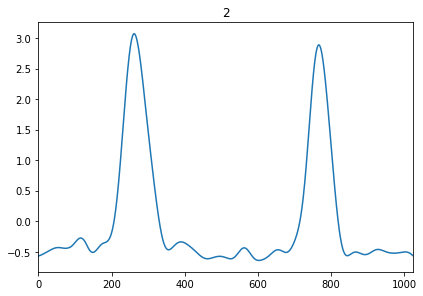

In [24]:
tfms = [None, [Categorize()]]
# tfms = None
# dsets = NumpyDatasets(X_on_disk, y_on_disk, tfms=tfms, sel_vars=None, sel_steps=None, splits=splits, preprocess=True)
dsets = TSDatasets(X_in_memory, y_in_memory, sel_vars=None, sel_steps=None, tfms=tfms, splits=splits, preprocess=True)
train_ds = dsets.train
valid_ds = dsets.valid
test_ds  = dsets.add_test(X_in_memory, y_in_memory)
print(valid_ds[0])
show_at(valid_ds, 0);

In [25]:
train_dl = TSDataLoader(train_ds, bs=64, shuffle=True, drop_last=True, num_workers=0)
valid_dl = TSDataLoader(valid_ds, bs=128, num_workers=0)
dls = TSDataLoaders(train_dl, valid_dl)
b = next(iter(dls.train))
b

(TSTensor(samples:64, vars:1, len:1024),
 TensorCategory([1, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 1, 2, 2, 1, 2, 1, 2, 0, 1, 2, 2, 2,
         0, 2, 2, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 1, 2, 1, 2,
         1, 1, 2, 2, 2, 2, 0, 2, 2, 1, 2, 0, 2, 2, 2, 1]))

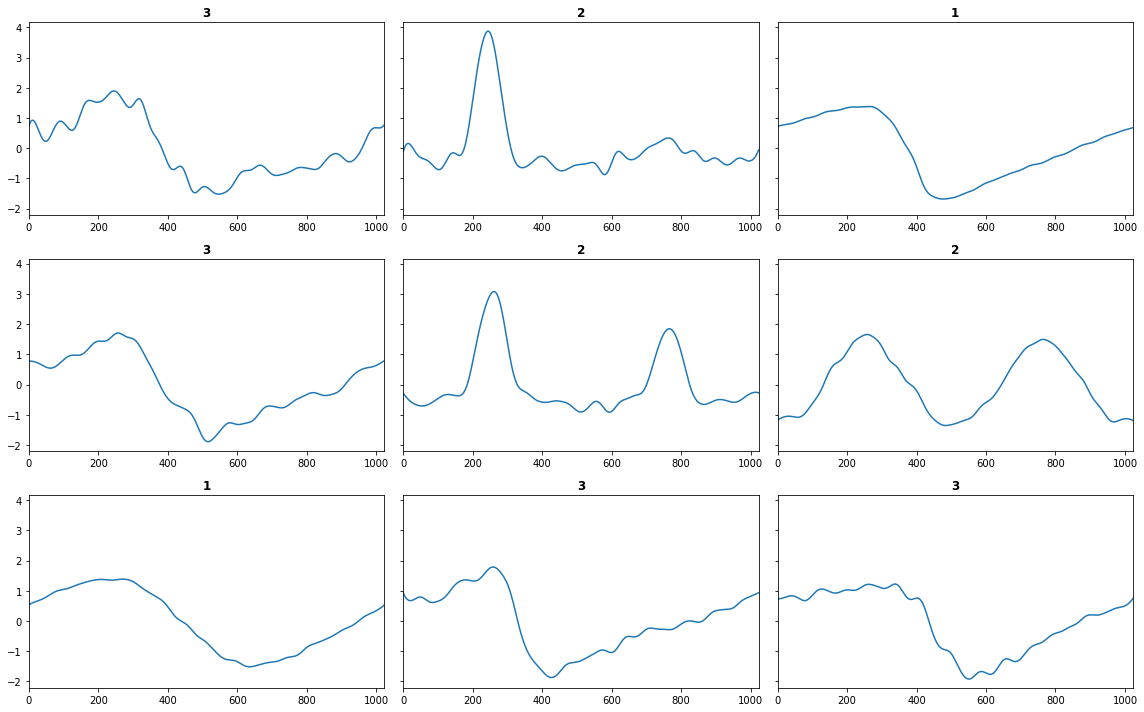

In [27]:
dls.train.show_batch(sharey=True)

Let's first establish another benchmark. 

If we think of it, the fastest and simplest way to create a batch to be used in fastai v2 would be to:

1. split the X and y between train and valid. This can be done at initialization. 

2. Slice the data based on random idx, cast the outputs to the expected classes, and create a tuple. 

This process takes about 150 µs. So it's very fast.

In [41]:
X_val = X_in_memory[splits[1]]
y_val = y_in_memory[splits[1]]
tuple((TSTensor(X_val[valid_idx]), TensorCategory(y_val[valid_idx])))

(TSTensor(samples:128, vars:1, len:1024),
 TensorCategory([3, 3, 2, 3, 3, 1, 2, 2, 3, 3, 1, 2, 3, 2, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3,
         3, 3, 3, 2, 2, 3, 3, 3, 1, 2, 3, 2, 2, 3, 3, 3, 3, 3, 3, 2, 1, 3, 3, 3,
         2, 3, 1, 3, 1, 3, 3, 3, 3, 2, 1, 3, 3, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 3,
         2, 2, 2, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3,
         3, 1, 1, 3, 2, 3, 2, 2, 2, 3, 3, 2, 3, 1, 2, 1, 2, 1, 3, 3, 3, 1, 3, 2,
         3, 3, 3, 3, 2, 3, 3, 3]))

In [42]:
%timeit tuple((TSTensor(X_val[valid_idx]), TensorCategory(y_val[valid_idx])))

10000 loops, best of 3: 165 µs per loop


Let's see how does this compare to NumpyDatasets when tfms are not preprocessed:

In [43]:
valid_ds[valid_idx]

(TSTensor(samples:128, vars:1, len:1024),
 TensorCategory([2, 2, 1, 2, 2, 0, 1, 1, 2, 2, 0, 1, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2,
         2, 2, 2, 1, 1, 2, 2, 2, 0, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 2,
         1, 2, 0, 2, 0, 2, 2, 2, 2, 1, 0, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2,
         1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2,
         2, 0, 0, 2, 1, 2, 1, 1, 1, 2, 2, 1, 2, 0, 1, 0, 1, 0, 2, 2, 2, 0, 2, 1,
         2, 2, 2, 2, 1, 2, 2, 2]))

In [46]:
# Preprocess = False
dsets = TSDatasets(X_in_memory, y_in_memory, sel_vars=None, sel_steps=None, tfms=tfms, splits=splits, preprocess=False)
valid_ds = dsets.valid
valid_dl = TSDataLoader(valid_ds, bs=128, num_workers=0)
%timeit valid_ds[valid_idx]

100 loops, best of 3: 12.8 ms per loop


This is about 100 times slower. This makes the dataloader almost 20 times slower than the simple Pytorch dataloder whe showed before.

In [0]:
%timeit cycle_dl(valid_dl)

1 loop, best of 3: 929 ms per loop


Let's see how is performance when data is preprocessed:

In [44]:
# Preprocess = True
dsets = TSDatasets(X_in_memory, y_in_memory, sel_vars=None, sel_steps=None, tfms=tfms, splits=splits, preprocess=True)
valid_ds = dsets.valid
valid_dl = TSDataLoader(valid_ds, bs=128, num_workers=0)
%timeit valid_ds[valid_idx]

1000 loops, best of 3: 442 µs per loop


Since we only perform slicing and casting at batch creation time, performance is closer to the slicing and casting we showed before, and about 30 times faster than when not preprocessed. [link text](https:// [link text](https://))

In [61]:
%timeit cycle_dl(valid_dl)

10 loops, best of 3: 49.6 ms per loop


😲 This is the same level of performance we had with the Pytorch dataloader, but much more flexible and with many additional benefits ❣️

Let's now compare the time to train the model.

In [286]:
# Preprocess = FALSE, Data in memory
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X_in_memory, y_in_memory, tfms=tfms, splits=splits, preprocess=False)
train_ds = dsets.train
valid_ds = dsets.valid
train_dl = TSDataLoader(train_ds, bs=64, shuffle=True, drop_last=True, num_workers=0)
valid_dl = TSDataLoader(valid_ds, bs=128, num_workers=0)
dls   = TSDataLoaders(train_dl, valid_dl, device=default_device())
model = InceptionTime(dls.vars, dls.c)
learn2 = Learner(dls, model, metrics=accuracy)
start = time.time()
learn2.fit_one_cycle(25, lr_max=1e-3)
print(time.time() - start)

epoch,train_loss,valid_loss,accuracy,time
0,0.711755,1.013949,0.577222,00:03
1,0.572842,0.647487,0.843613,00:03
2,0.483877,0.435641,0.853205,00:03
3,0.395426,1.202036,0.852841,00:03
4,0.329816,0.352012,0.846042,00:03
5,0.272237,0.223510,0.923264,00:03
6,0.226219,0.178971,0.933463,00:03
7,0.204350,0.288009,0.878946,00:03
8,0.179450,0.128417,0.973531,00:03
9,0.156347,0.124633,0.969888,00:03


98.03326082229614


⚠️ This NumpyDataLoader is already a bit faster than fastai v1. But we have not yet used preprocess = True. 

In [63]:
# Preprocess = TRUE, Data in memory
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X_in_memory, y_in_memory, tfms=tfms, splits=splits, preprocess=True)
train_ds = dsets.train
valid_ds = dsets.valid
train_dl = TSDataLoader(train_ds, bs=64, shuffle=True, drop_last=True, num_workers=0)
valid_dl = TSDataLoader(valid_ds, bs=128, num_workers=0)
dls   = TSDataLoaders(train_dl, valid_dl, device=default_device())
model = InceptionTime(dls.vars, dls.c)
learn = Learner(dls, model, metrics=accuracy)
start = time.time()
learn.fit_one_cycle(25, lr_max=1e-3)
print(time.time() - start)

epoch,train_loss,valid_loss,accuracy,time
0,0.835611,1.038498,0.577222,00:02
1,0.667096,0.729662,0.837664,00:02
2,0.554115,0.503784,0.852720,00:02
3,0.465944,0.498262,0.856241,00:02
4,0.396884,0.292383,0.917557,00:02
5,0.330362,0.341773,0.856484,00:02
6,0.279558,0.254410,0.878825,00:02
7,0.239170,0.257100,0.868747,00:02
8,0.206538,1.570402,0.410879,00:02
9,0.181974,0.357201,0.853205,00:02


74.28572797775269


🍻 🎉 I think this is a great result. It means that just preprocessing the item transforms can reduce training time by almost 25%, and almost 50% from the generic datablock API. 

In [62]:
# Preprocess = TRUE, Data on disk
tfms = [None, [Categorize()]]
dsets = TSDatasets(X_on_disk, y_on_disk, tfms=tfms, splits=splits, preprocess=True)
train_ds = dsets.train
valid_ds = dsets.valid
train_dl = TSDataLoader(train_ds, bs=64, shuffle=True, drop_last=True)
valid_dl = TSDataLoader(valid_ds, bs=128)
dls = TSDataLoaders(train_dl, valid_dl, device=default_device())
model = InceptionTime(dls.vars, dls.c)
learn = Learner(dls, model, metrics=accuracy)
start = time.time()
learn.fit_one_cycle(25, lr_max=1e-3)
print(time.time() - start)

epoch,train_loss,valid_loss,accuracy,time
0,0.803100,1.085054,0.374211,00:03
1,0.635497,0.690007,0.841064,00:03
2,0.535171,0.459494,0.851991,00:03
3,0.448712,0.707463,0.498057,00:03
4,0.381802,0.645756,0.624089,00:03
5,0.327073,1.450277,0.838878,00:03
6,0.277469,0.564345,0.855512,00:03
7,0.233669,0.339163,0.844585,00:03
8,0.202157,0.104090,0.976445,00:03
9,0.177261,0.106450,0.974745,00:03


82.3660249710083


⚠️ This is also very important, as it means we can now train very large datasets with a good performance without loading data in memory. It takes around 10% longer.

NumpyDatasets and NumpyDataLoader share all the benefits of fastai v2:

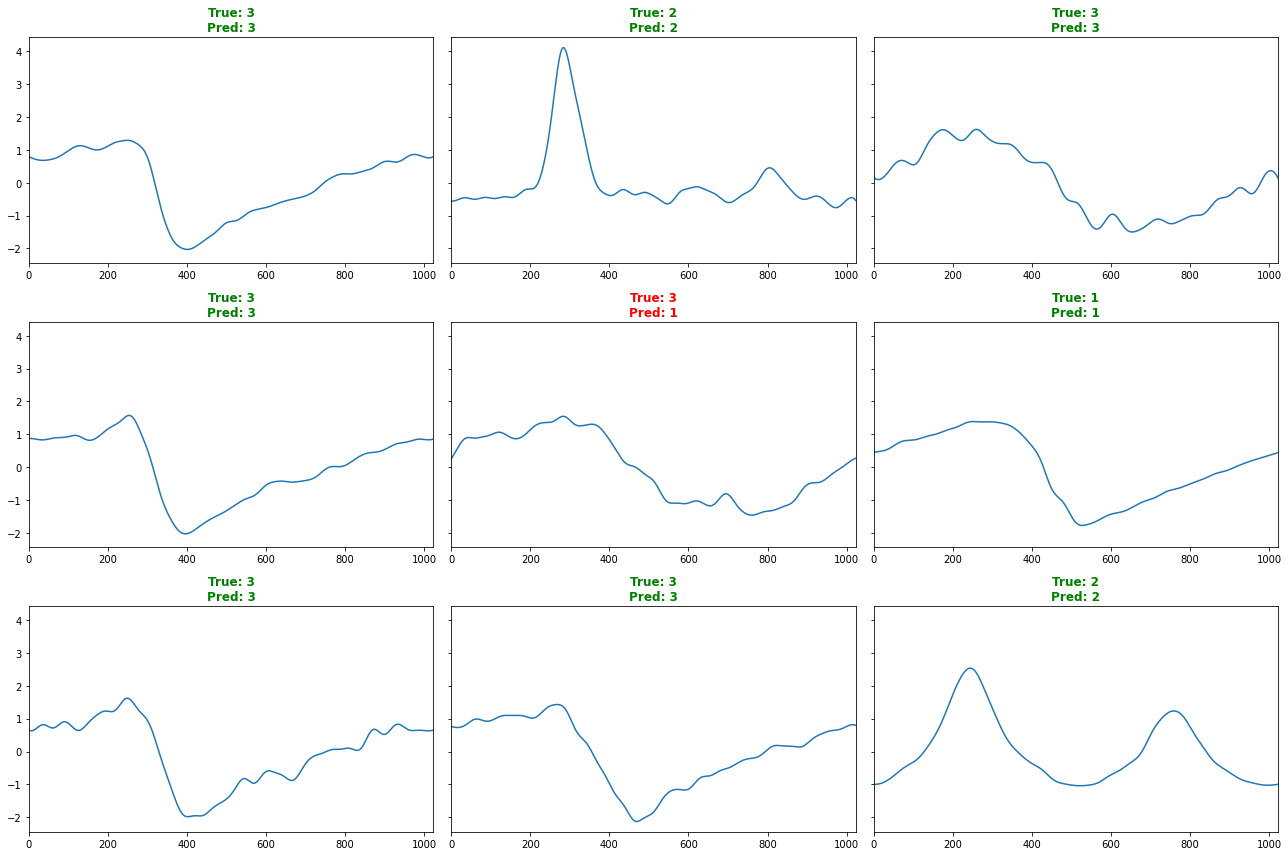

In [26]:
learn.show_results(sharey=True)

## End-to-end process 🏁

We are now goind to show the end-to-end process including: 

* data loading
* datasets & dataloaders creation
* training
* getting predictions
* exporting the learner and datasets
* reloading the learner and datasets
* adding additional data
* creating predictions for new data

### Data loading

In this notebook, we'll use one of the most widely used time series classification databases: UEA & UCR Time Series Classification Repository. As of Sep 2019 it contains 128 univariate datasets and 30 multivariate datasets.

In the case of UCR data it's very easy to get data loaded. Let's select a dataset. You can modify this and select any one from the previous lists (univariate of multivariate).

This framework I'm using can deal with numpy arrays on disk (np.memmap). If you are not familiar with them, you may want to take a look at the 00_How_to_efficiently_work_with_very_large_numpy_arrays.ipynb I've also shared.

In [12]:
pprint.pprint(get_UCR_univariate_list())

['ACSF1',
 'Adiac',
 'AllGestureWiimoteX',
 'AllGestureWiimoteY',
 'AllGestureWiimoteZ',
 'ArrowHead',
 'Beef',
 'BeetleFly',
 'BirdChicken',
 'BME',
 'Car',
 'CBF',
 'Chinatown',
 'ChlorineConcentration',
 'CinCECGTorso',
 'Coffee',
 'Computers',
 'CricketX',
 'CricketY',
 'CricketZ',
 'Crop',
 'DiatomSizeReduction',
 'DistalPhalanxOutlineAgeGroup',
 'DistalPhalanxOutlineCorrect',
 'DistalPhalanxTW',
 'DodgerLoopDay',
 'DodgerLoopGame',
 'DodgerLoopWeekend',
 'Earthquakes',
 'ECG200',
 'ECG5000',
 'ECGFiveDays',
 'ElectricDevices',
 'EOGHorizontalSignal',
 'EOGVerticalSignal',
 'EthanolLevel',
 'FaceAll',
 'FaceFour',
 'FacesUCR',
 'FiftyWords',
 'Fish',
 'FordA',
 'FordB',
 'FreezerRegularTrain',
 'FreezerSmallTrain',
 'Fungi',
 'GestureMidAirD1',
 'GestureMidAirD2',
 'GestureMidAirD3',
 'GesturePebbleZ1',
 'GesturePebbleZ2',
 'GunPoint',
 'GunPointAgeSpan',
 'GunPointMaleVersusFemale',
 'GunPointOldVersusYoung',
 'Ham',
 'HandOutlines',
 'Haptics',
 'Herring',
 'HouseTwenty',
 'Inli

In [13]:
pprint.pprint(get_UCR_multivariate_list())

['ArticularyWordRecognition',
 'AtrialFibrillation',
 'BasicMotions',
 'CharacterTrajectories',
 'Cricket',
 'DuckDuckGeese',
 'EigenWorms',
 'Epilepsy',
 'ERing',
 'EthanolConcentration',
 'FaceDetection',
 'FingerMovements',
 'HandMovementDirection',
 'Handwriting',
 'Heartbeat',
 'InsectWingbeat',
 'JapaneseVowels',
 'Libras',
 'LSST',
 'MotorImagery',
 'NATOPS',
 'PEMS-SF',
 'PenDigits',
 'PhonemeSpectra',
 'RacketSports',
 'SelfRegulationSCP1',
 'SelfRegulationSCP2',
 'SpokenArabicDigits',
 'StandWalkJump',
 'UWaveGestureLibrary']


In [14]:
dsid = 'NATOPS'
X_train, y_train, X_valid, y_valid = get_UCR_data(dsid, parent_dir='./data/UCR/', verbose=True, on_disk=True)
X_in_memory = np.concatenate((X_train, X_valid))
y_in_memory = np.concatenate((y_train, y_valid))
folder = './data/UCR'
np.save(f'{folder}/{dsid}/X.npy', X_in_memory)
np.save(f'{folder}/{dsid}/y.npy', y_in_memory)
X_on_disk = np.load(f'{folder}/{dsid}/X.npy', mmap_mode='r')
y_on_disk = np.load(f'{folder}/{dsid}/y.npy', mmap_mode='r')
splits = (L(list(np.arange(len(X_train)))), L(list(np.arange(len(X_train), len(X_on_disk)))))

Dataset: NATOPS
X_train: (180, 24, 51)
y_train: (180,)
X_valid: (180, 24, 51)
y_valid: (180,) 



### Dataloaders creation

In [15]:
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X_in_memory, y_in_memory, tfms=tfms, splits=splits, preprocess=True)
train_ds = dsets.train
valid_ds = dsets.valid
train_dl = TSDataLoader(train_ds, bs=64, shuffle=True, drop_last=True, num_workers=0)
valid_dl = TSDataLoader(valid_ds, bs=128, num_workers=0)
dls   = TSDataLoaders(train_dl, valid_dl, device=default_device())

### Training

In [16]:
model = InceptionTime(dls.vars, dls.c)
learn = Learner(dls, model, metrics=accuracy)
learn.fit_one_cycle(25, lr_max=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.813564,1.792388,0.205556,00:06
1,1.718430,1.785498,0.333333,00:07
2,1.591968,1.767287,0.372222,00:06
3,1.422343,1.729302,0.472222,00:06
4,1.250862,1.658802,0.755556,00:06
5,1.108016,1.537521,0.761111,00:06
6,0.990250,1.377754,0.744444,00:06
7,0.897909,1.226413,0.677778,00:05
8,0.810363,1.033540,0.716667,00:05
9,0.742156,0.804354,0.805556,00:05


### Predict

In [17]:
train_probas, train_targets, train_preds = learn.get_preds(ds_idx=0, with_decoded=True, save_preds=None, save_targs=None)
valid_probas, valid_targets, valid_preds = learn.get_preds(ds_idx=1, with_decoded=True, save_preds=None, save_targs=None)
valid_probas, valid_targets, valid_preds

(tensor([[0.0034, 0.0065, 0.0027, 0.9788, 0.0061, 0.0025],
         [0.0034, 0.0049, 0.0030, 0.0089, 0.9666, 0.0133],
         [0.0031, 0.0029, 0.0012, 0.0050, 0.0039, 0.9839],
         ...,
         [0.0016, 0.0022, 0.0011, 0.0054, 0.9834, 0.0063],
         [0.0034, 0.0063, 0.0028, 0.9794, 0.0059, 0.0023],
         [0.0047, 0.0054, 0.0031, 0.8929, 0.0886, 0.0053]]),
 tensor([3, 4, 5, 0, 3, 2, 1, 2, 2, 0, 4, 3, 2, 4, 1, 0, 4, 0, 4, 0, 2, 3, 5, 5,
         1, 2, 1, 0, 1, 4, 2, 3, 5, 4, 3, 5, 3, 0, 3, 5, 4, 2, 1, 5, 0, 2, 4, 3,
         2, 2, 2, 2, 0, 2, 0, 1, 0, 0, 4, 1, 4, 5, 0, 5, 1, 1, 1, 2, 4, 1, 5, 3,
         0, 3, 4, 3, 1, 4, 4, 2, 0, 3, 3, 5, 1, 5, 2, 5, 5, 4, 4, 2, 4, 3, 5, 2,
         1, 5, 0, 3, 0, 5, 3, 5, 0, 5, 5, 0, 2, 5, 0, 1, 1, 4, 1, 0, 0, 2, 4, 1,
         0, 3, 4, 3, 1, 2, 2, 2, 2, 0, 4, 0, 0, 1, 3, 4, 4, 2, 1, 1, 1, 4, 4, 3,
         1, 4, 0, 4, 5, 5, 1, 5, 3, 3, 5, 5, 4, 3, 5, 1, 3, 2, 3, 0, 1, 3, 0, 2,
         5, 2, 1, 5, 3, 1, 0, 5, 2, 4, 3, 3]),
 tensor([3, 4, 5

### Export learner and datasets

In [18]:
# Save the dataset
dsets_fname = 'dsets'
torch.save(dsets, dsets_fname)

# Saves the model along with optimizer
save_fname = 'learner'
learn.save(save_fname)

# Export learn without the items (data) and the optimizer state for inference
export_fname = 'export.pkl'
learn.export(export_fname)

In [19]:
del dsets, learn

### Reload learner and datasets

In [20]:

# Let's build the learner again
dsets_fname = 'dsets'
save_fname = 'learner'
export_fname = 'export.pkl'

dsets = torch.load(dsets_fname)
learn = load_learner(export_fname, cpu=False)
learn.load(save_fname)
learn.dls[0].dataset = dsets.train
learn.dls[1].dataset = dsets.valid

In [21]:
(valid_targets == valid_preds).float().mean()

tensor(0.9278)

⚠️ This is the same accuracy we got in the trained model, which means we've been able to export and reload it successfully!

### Add additional labeled test data

In [22]:
# Labeled test data
# Let's first delete the datasets and learner
del dsets, learn

# Let's build the learner again
dsets_fname = 'dsets'
save_fname = 'learner'
export_fname = 'export.pkl'

dsets = torch.load(dsets_fname)
learn = load_learner(export_fname, cpu=False)
learn.load(save_fname)

# And now we load a new dataset
test_ds = dsets.add_test(X_in_memory, y_in_memory)
test_dl = learn.dls[1].new(test_ds)
b = next(iter(test_dl))
b

(TSTensor(samples:128, vars:24, len:51),
 tensor([3, 2, 2, 3, 2, 4, 0, 5, 2, 1, 5, 0, 3, 5, 2, 1, 2, 1, 1, 5, 3, 2, 4, 3,
         0, 5, 2, 4, 4, 4, 2, 4, 2, 4, 3, 4, 2, 0, 3, 5, 2, 3, 3, 5, 0, 5, 1, 0,
         0, 5, 3, 0, 2, 2, 1, 0, 4, 0, 1, 4, 3, 4, 1, 4, 0, 5, 2, 0, 1, 0, 2, 3,
         3, 2, 4, 1, 1, 2, 2, 5, 5, 0, 1, 4, 1, 1, 3, 4, 5, 3, 1, 2, 0, 2, 0, 4,
         5, 5, 4, 4, 5, 3, 1, 0, 1, 1, 1, 5, 4, 3, 2, 3, 0, 2, 4, 4, 4, 3, 2, 5,
         2, 0, 2, 3, 0, 5, 1, 0]))

In [23]:
test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
test_probas, test_targets, test_preds

(tensor([[2.2768e-03, 2.6541e-03, 1.1828e-03, 9.8878e-01, 3.0928e-03, 2.0088e-03],
         [8.6462e-04, 7.3501e-03, 9.8594e-01, 7.3698e-04, 1.5583e-03, 3.5482e-03],
         [1.6953e-03, 1.4830e-02, 9.7616e-01, 1.1429e-03, 1.9768e-03, 4.1955e-03],
         ...,
         [1.5765e-03, 2.1912e-03, 1.1414e-03, 5.3569e-03, 9.8343e-01, 6.3020e-03],
         [3.3653e-03, 6.2546e-03, 2.7746e-03, 9.7943e-01, 5.9143e-03, 2.2615e-03],
         [4.7473e-03, 5.3857e-03, 3.0518e-03, 8.9294e-01, 8.8607e-02, 5.2703e-03]]),
 tensor([3, 2, 2, 3, 2, 4, 0, 5, 2, 1, 5, 0, 3, 5, 2, 1, 2, 1, 1, 5, 3, 2, 4, 3,
         0, 5, 2, 4, 4, 4, 2, 4, 2, 4, 3, 4, 2, 0, 3, 5, 2, 3, 3, 5, 0, 5, 1, 0,
         0, 5, 3, 0, 2, 2, 1, 0, 4, 0, 1, 4, 3, 4, 1, 4, 0, 5, 2, 0, 1, 0, 2, 3,
         3, 2, 4, 1, 1, 2, 2, 5, 5, 0, 1, 4, 1, 1, 3, 4, 5, 3, 1, 2, 0, 2, 0, 4,
         5, 5, 4, 4, 5, 3, 1, 0, 1, 1, 1, 5, 4, 3, 2, 3, 0, 2, 4, 4, 4, 3, 2, 5,
         2, 0, 2, 3, 0, 5, 1, 0, 5, 3, 0, 1, 4, 5, 5, 0, 5, 3, 5, 1, 0, 0, 0, 3,


### Add additional unlabeled test data

In [24]:
# Unlabeled test data
# Let's first delete the datasets and learner
del dsets, learn

# Let's build the learner again
dsets_fname = 'dsets'
save_fname = 'learner'
export_fname = 'export.pkl'

dsets = torch.load(dsets_fname)
learn = load_learner(export_fname, cpu=False)
learn.load(save_fname)

# And now we load a new dataset
test_ds = dsets.add_test(X_in_memory)
test_dl = learn.dls[1].new(test_ds)
b = next(iter(test_dl))
b

(TSTensor(samples:128, vars:24, len:51),)

In [25]:
test_probas, *_ = learn.get_preds(dl=test_dl, save_preds=None)
test_probas

tensor([[2.2768e-03, 2.6541e-03, 1.1828e-03, 9.8878e-01, 3.0928e-03, 2.0088e-03],
        [8.6462e-04, 7.3501e-03, 9.8594e-01, 7.3698e-04, 1.5583e-03, 3.5482e-03],
        [1.6953e-03, 1.4830e-02, 9.7616e-01, 1.1429e-03, 1.9768e-03, 4.1955e-03],
        ...,
        [1.5765e-03, 2.1912e-03, 1.1414e-03, 5.3569e-03, 9.8343e-01, 6.3020e-03],
        [3.3653e-03, 6.2546e-03, 2.7746e-03, 9.7943e-01, 5.9143e-03, 2.2615e-03],
        [4.7473e-03, 5.3857e-03, 3.0518e-03, 8.9294e-01, 8.8607e-02, 5.2703e-03]])

### Add additional unlabeled data

In [26]:
# Unlabeled dataset
# Let's first delete the datasets and learner
del dsets, learn

# Let's build the learner again
dsets_fname = 'dsets'
save_fname = 'learner'
export_fname = 'export.pkl'

dsets = torch.load(dsets_fname)
learn = load_learner(export_fname, cpu=False)
learn.load(save_fname)

# And now we load a new datasets
unlabeled_ds = dsets.add_unlabeled(X_in_memory)
unlabeled_dl = learn.dls[1].new(unlabeled_ds)
b = next(iter(unlabeled_dl))
b

(TSTensor(samples:128, vars:24, len:51),)

In [27]:
u_probas, *_ = learn.get_preds(dl=unlabeled_dl, save_preds=None)
u_probas

tensor([[2.2768e-03, 2.6541e-03, 1.1828e-03, 9.8878e-01, 3.0928e-03, 2.0088e-03],
        [8.6462e-04, 7.3501e-03, 9.8594e-01, 7.3698e-04, 1.5583e-03, 3.5482e-03],
        [1.6953e-03, 1.4830e-02, 9.7616e-01, 1.1429e-03, 1.9768e-03, 4.1955e-03],
        ...,
        [1.5765e-03, 2.1912e-03, 1.1414e-03, 5.3569e-03, 9.8343e-01, 6.3020e-03],
        [3.3653e-03, 6.2546e-03, 2.7746e-03, 9.7943e-01, 5.9143e-03, 2.2615e-03],
        [4.7473e-03, 5.3857e-03, 3.0518e-03, 8.9294e-01, 8.8607e-02, 5.2703e-03]])

## Conclusions 🧠

We now have a dataloader that works with numpy arrays and meets all the requirements we set at the beginning of this notebook. The key benefits are: 

* We can use it with numpy arrays (or anything that can be converted into np arrays) with **any number of dimensions**
* Easy to use scikit-learn type of API (X, (y)), useful for **labeled and unlabeled datasets**
* We can also use **larger than RAM datasets**, keeping data on disk.
* It has all the benefits of being integrated with fastai v2: 
    * Use item and batch tfms
    * Show batch (with tfms)
    * Show results
    * We can export the learner, and predict on new data
* And almost 40% faster than fastai v1 and 50% faster than generic fastai v2 (for numpy arrays)